In [66]:
# encoding: utf-8
# Author: Zhuangwei Kang

import os, sys
import matplotlib.pyplot as plt
from matplotlib import style
sys.path.append('../../')
from datapsr import *
import numpy as np
style.use(['classic'])
plt.rc('axes', axisbelow=True)
dpi=600

[ 7.2 30.5 78.4 92.6 93.7]
[ 5.2 25.3 59.1 84.2 90.3]
[ 5.8 28.8 62.9 91.1 93.4]
[ 5.7 29.5 67.7 91.9 93.4]
[ 4.8 23.  56.5 80.2 90.2]


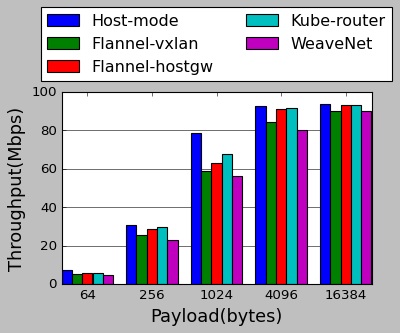

In [67]:
udp_plugins = ['hostnetwork-udp', 'flannel-vxlan-udp', 'flannel-hostgw-udp', 'kube-router-udp', 'weavenet-udp']
tcp_plugins = ['hostnetwork-tcp', 'flannel-vxlan-tcp', 'flannel-hostgw-tcp', 'kube-router-tcp', 'weavenet-tcp']
data_len = [64, 256, 1024, 4096, 16384]
udp_reliable_perf, _ = load_data(np.arange(len(data_len)), udp_plugins)
tcp_besteffort_perf, _ = load_data(np.arange(24, 29), tcp_plugins)
plt.figure(figsize=(5,3))
x = np.arange(len(data_len))
xticks=['64B', '256B', '1K', '4K', '16K']
plt.xticks(range(len(data_len)), xticks)
# plt.ylim(0, 100)
labels = ['Host-mode', 'Flannel-vxlan', 'Flannel-hostgw', 'Kube-router', 'WeaveNet']
# for i, cni in enumerate(udp_plugins):
#     throughput = udp_reliable_perf[udp_reliable_perf['cni'] == cni]['mbps(ave)']
#     plt.scatter(x, throughput, label='-'.join(cni.split('-')[:-1]).upper()+'-UDP', marker='o', color='C%i' % i)
markers = ['^', 'o', 'X', 'P', 's']
# plt.ylim(0.4, 1.0)
x = np.arange(len(data_len))
plt.xticks(x, data_len)
total_width, n = 0.8, len(udp_plugins)
width = total_width / n
x = x - (total_width - width) / 2
baseline = tcp_besteffort_perf[tcp_besteffort_perf['cni'] == 'hostnetwork-tcp']['packets/s(ave)'].to_numpy()
for i, cni in enumerate(tcp_plugins):
    throughput = tcp_besteffort_perf[tcp_besteffort_perf['cni'] == cni]['mbps(ave)'].to_numpy()
    plt.bar(x+i*width, throughput, label=labels[i], width=width)
    print(throughput)

# plt.yticks(np.arange(4,12,2)/10)
plt.legend(bbox_to_anchor=(0.5, 1.25), ncol=2, loc='center', scatterpoints = 1)
plt.xlabel('Payload(bytes)', fontsize=16)
plt.ylabel('Throughput(Mbps)', fontsize=16)
plt.grid(linestyle='-', axis='y')
plt.savefig('throughput.png', dpi=dpi, bbox_inches='tight')


[1.26, 1.36, 0.97, 0.99, 1.0]
[1.68, 2.02, 1.24, 0.99, 0.99]
[1.45, 1.79, 1.03, 0.98, 1.0]
[1.39, 1.83, 1.1, 0.99, 1.0]
[1.78, 2.11, 1.38, 1.02, 0.99]
ipykernel_launcher:10: MatplotlibDeprecationWarning: Using a string of single character colors as a color sequence is deprecated. Use an explicit list instead.


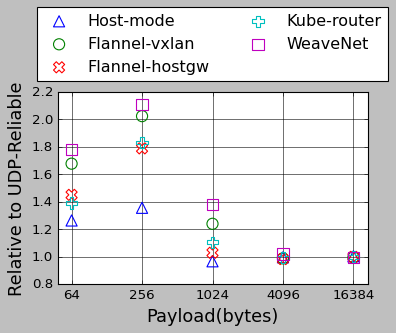

In [68]:
plt.figure(figsize=(5,3))
x = np.arange(len(data_len))
plt.xticks(x, data_len)
total_width, n = 0.8, len(udp_plugins)
width = total_width / n
for i in range(len(udp_plugins)):
    udp_throughput = udp_reliable_perf[udp_reliable_perf['cni'] == udp_plugins[i]]['mbps(ave)']
    tcp_throughput = tcp_besteffort_perf[tcp_besteffort_perf['cni'] == tcp_plugins[i]]['mbps(ave)']
    difference = tcp_throughput/udp_throughput
    plt.scatter(x, difference, label=labels[i], marker=markers[i], c='',edgecolors='C%d'%(i), s=100)
    print(difference.round(2).to_list())

plt.legend(bbox_to_anchor=(0.5, 1.25), ncol=2, loc='center', scatterpoints = 1)
plt.xlabel('Payload(bytes)', fontsize=16)
plt.ylabel('Relative to UDP-Reliable', fontsize=16)
plt.grid(linestyle='-')
plt.savefig('tcp_vs_udp_throughput.png', dpi=dpi, bbox_inches='tight')

Description:  Reliability can be implemented at the transport layer or application layer in DDS, corresponding to TCP/TLS and DDS Reliability QoS policy, respectively. Since TCP itself guarantees reliable transmission, we can configure the DDS QoS policy as "BestEffort" to avoid redundant delivery acknowledgment at the application level. In contrast, UDP needs to coordinate with the "Reliable" QoS to ensure messages are transmitted reliably. Our previous experiment has shown the DDS performance with the UDP+Reliable configuration under various CNIs, while this experiment intends to expose that under the TCP+BestEffort knob setting. Therefore, we eventually aim at identifying the optimal configuration and K8s network plugin for reliable communication in DDS.

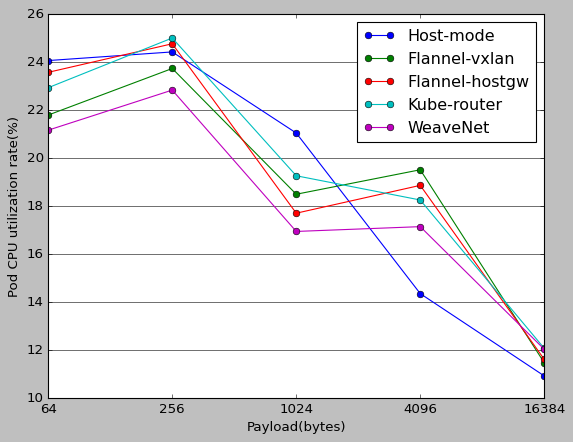

In [69]:
# _, perf = load_data(np.arange(24, 30), tcp_plugins)
plt.xticks(range(len(data_len)), data_len)
for i, cni in enumerate(tcp_plugins):
    cpu = tcp_besteffort_perf[tcp_besteffort_perf['cni'] == cni]['cpu']
    plt.plot(np.arange(len(data_len)), cpu, label=labels[i], marker='o')
# plt.ylim(0, 100)
plt.legend()
plt.xlabel('Payload(bytes)')
plt.ylabel('Pod CPU utilization rate(%)')
plt.grid(axis='y', linestyle='-')
plt.show()

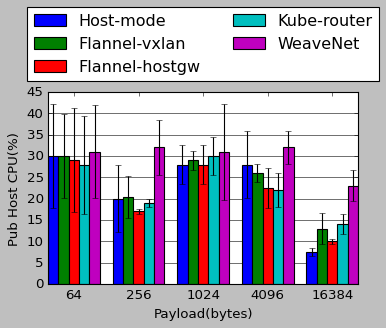

In [70]:
plt.figure(figsize=(5,3))
plt.xticks(range(len(data_len)), data_len)
pub_host_cpu = {}
sub_host_cpu = {}
x = np.arange(len(data_len))
# markers = ['o', '^', 'd', 'P']

baselines = []
for j, cni in enumerate(udp_plugins):
    pub_cpu = []
    pub_cpu_std = []
    sub_cpu = []
    sub_cpu_std = []
    for i in np.arange(5):
        data = pd.read_csv('throughputTest/%s/test-%d/metrics.csv' % (cni, i))
#         print(data)
        pub_cpu.append(data[data['name'] == 'raspberrypi87']['cpu%(avg)'])
        sub_cpu.append(data[data['name'] == 'raspberrypi89']['cpu%(avg)'])
        pub_cpu_std.append(data[data['name'] == 'raspberrypi87']['cpu%(std)'])
        sub_cpu_std.append(data[data['name'] == 'raspberrypi89']['cpu%(std)'])
    baselines.append(np.array(pub_cpu))
        
x = np.arange(len(data_len))
plt.xticks(x, data_len)
total_width, n = 0.8, len(udp_plugins)
width = total_width / n
x = x - (total_width - width) / 2
for j, cni in enumerate(tcp_plugins):
    pub_cpu = []
    pub_cpu_std = []
    sub_cpu = []
    sub_cpu_std = []
    for i in np.arange(24, 29):
        data = pd.read_csv('throughputTest/%s/test-%d/metrics.csv' % (cni, i))
        pub_cpu.append(data[data['name'] == 'raspberrypi87']['cpu%(90%)'])
        sub_cpu.append(data[data['name'] == 'raspberrypi89']['cpu%(90%)'])
        pub_cpu_std.append(data[data['name'] == 'raspberrypi87']['cpu%(std)'])
        sub_cpu_std.append(data[data['name'] == 'raspberrypi89']['cpu%(std)'])
    
    plt.bar(x+j*width, np.reshape(np.array(pub_cpu), len(x)), yerr=np.reshape(np.array(pub_cpu_std), len(x)), width=width, label=labels[j])

# plt.ylim(0.5, 2.5)
plt.legend(bbox_to_anchor=(0.5, 1.25), ncol=2, loc='center')
plt.xlabel('Payload(bytes)')
plt.ylabel('Pub Host CPU(%)')
plt.grid(axis='y', linestyle='-')
plt.savefig('cpu.png', dpi=dpi, bbox_inches='tight')

[173.7 195.8 232.  243.5 241.9]
[250.4 242.3 269.4 312.8 289.2]
[183.3 195.6 257.6 268.7 227.3]
[216.2 213.9 233.9 266.8 246.6]
[710.8 246.6 285.1 323.8 342.4]


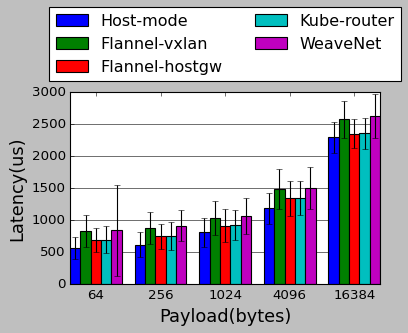

In [71]:
plt.figure(figsize=(5,3))
x = np.arange(len(data_len))
plt.xticks(x, data_len)
total_width, n = 0.8, len(udp_plugins)
width = total_width / n
x = x - (total_width - width) / 2

_, udp_reliable_perf = load_data(np.arange(len(data_len)), udp_plugins, latencyTest=True)
_, tcp_besteffort_perf = load_data(np.arange(24, 29), tcp_plugins, latencyTest=True)

baseline = tcp_besteffort_perf[tcp_besteffort_perf['cni'] == 'hostnetwork-tcp']['latencyave'].to_numpy()
for i, cni in enumerate(tcp_plugins):
    lat = tcp_besteffort_perf[tcp_besteffort_perf['cni'] == cni]['latencyave'].to_numpy()
    lat_err = tcp_besteffort_perf[tcp_besteffort_perf['cni'] == cni]['std'].to_numpy()
    plt.bar(x+i*width, lat, yerr=lat_err, label=labels[i], width=width)
    # print(lat)
    # print('----------')
    print(lat_err)

# plt.ylim(1.0, 1.5)
plt.legend(bbox_to_anchor=(0.5, 1.25), ncol=2, loc='center', scatterpoints = 1)
plt.xlabel('Payload(bytes)', fontsize=16)
plt.ylabel('Latency(us)', fontsize=16)
plt.grid(linestyle='-', axis='y')
plt.savefig('latency.png', dpi=dpi, bbox_inches='tight')

ipykernel_launcher:17: MatplotlibDeprecationWarning: Using a string of single character colors as a color sequence is deprecated. Use an explicit list instead.
[0.99, 0.99, 0.98, 0.95, 1.0]
[1.03, 1.01, 0.99, 0.96, 0.87]
[1.06, 1.05, 0.99, 0.92, 0.85]
[1.09, 1.08, 1.03, 0.92, 0.83]
[0.97, 0.99, 0.94, 0.94, 0.87]


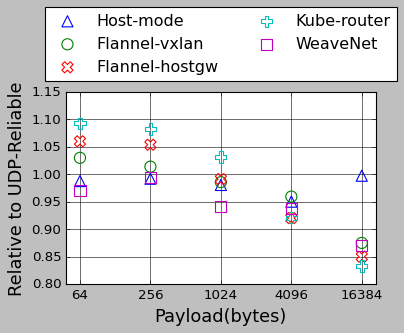

In [72]:
plt.figure(figsize=(5,3))
x = np.arange(len(data_len))
plt.xticks(x, data_len)
total_width, n = 0.8, len(udp_plugins)
width = total_width / n
# x = x - (total_width - width) /2

_, udp_reliable_perf = load_data(np.arange(len(data_len)), udp_plugins, latencyTest=True)
_, tcp_besteffort_perf = load_data(np.arange(24, 29), tcp_plugins, latencyTest=True)

for i in range(len(tcp_plugins)):
    tcp_lat = tcp_besteffort_perf[tcp_besteffort_perf['cni'] == tcp_plugins[i]]['latencyave']
    udp_lat = udp_reliable_perf[udp_reliable_perf['cni'] == udp_plugins[i]]['latencyave']
    tcp_lat_std = tcp_besteffort_perf[tcp_besteffort_perf['cni'] == tcp_plugins[i]]['std']
    diff = tcp_lat/udp_lat
    diff_std = tcp_lat_std / udp_lat
    plt.scatter(x, diff, label=labels[i], marker=markers[i], c='',edgecolors='C%d'%(i), s=100)
    print(diff.round(2).to_list())

# plt.ylim(0.6, 1.8)
# plt.yticks(np.arange(6,13,2)/10)
plt.legend(bbox_to_anchor=(0.5, 1.25), ncol=2, loc='center', scatterpoints = 1)
plt.xlabel('Payload(bytes)', fontsize=16)
plt.ylabel('Relative to UDP-Reliable', fontsize=16)
plt.grid(linestyle='-')
plt.savefig('tcp_vs_udp_latency.png', dpi=dpi, bbox_inches='tight')

ipykernel_launcher:50: UserWarning: You have mixed positional and keyword arguments, some input may be discarded.


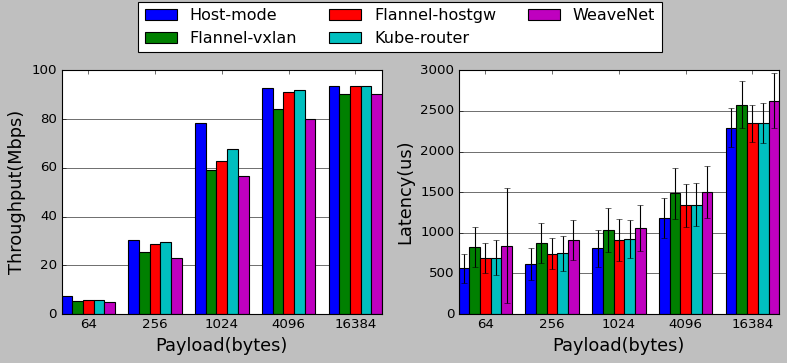

In [73]:
thp = [[ 7.2, 30.5, 78.4, 92.6, 93.7],
[ 5.2, 25.3, 59.1, 84.2, 90.3],
[ 5.8, 28.8, 62.9, 91.1 ,93.4],
[ 5.7, 29.5, 67.7 ,91.9 ,93.4],
[ 4.8 ,23,  56.5 ,80.2 ,90.2]]

lat = [[ 561,  614,  807, 1181,2293.],
[ 824,  875, 1035, 1485, 2573],
[ 688,  744,  911, 1337, 2347],
[ 693,  748,  918, 1347, 2352],
[ 842,  914, 1061, 1502, 2627]]

lat_std = [[173.7, 195.8, 232,  243.5, 241.9],
[250.4, 242.3, 269.4, 312.8, 289.2],
[183.3, 195.6, 257.6, 268.7, 227.3],
[216.2, 213.9, 233.9, 266.8, 246.6],
[710.8, 246.6, 285.1, 323.8, 342.4]]

fig, ax = plt.subplots(1, 2, figsize=(10, 4), sharex=True)
bars = []
def helper(i, j, data, err, xlabel, ylabel, title=None):
    global ax, bars
    x = np.arange(len(data_len))
    total_width, n = 0.8, len(labels)
    width = total_width / n
    x = x - (total_width - width) / 2
    if err is not None:
        ax[j].bar(x+i*width, data[i], width=width, yerr=err[i])
    else:
        ax[j].bar(x+i*width, data[i], width=width)
    ax[j].grid(linestyle='-', axis='y')
    ax[j].set_ylabel(ylabel, fontsize=16)
    ax[j].set_xlabel(xlabel, fontsize=16)
    ax[j].set_title(title, fontsize=16)
    bars.append(ax[j])


plt.xticks(x, data_len)

for j in range(5):
    helper(j, 0, thp, None, 'Payload(bytes)', 'Throughput(Mbps)')
for j in range(5):
    helper(j, 1, lat, lat_std, 'Payload(bytes)', 'Latency(us)')

fig.legend(bars[:5],     # The line objects
           labels=labels,   # The labels for each line
           loc="center",   # Position of legend
           borderaxespad=0.1,    # Small spacing around legend box
           bbox_to_anchor=(0.5, 1.05),
           ncol=3
           )
plt.tight_layout()
plt.savefig('cni.png', dpi=600, bbox_inches='tight')

ipykernel_launcher:23: MatplotlibDeprecationWarning: Using a string of single character colors as a color sequence is deprecated. Use an explicit list instead.
ipykernel_launcher:43: UserWarning: You have mixed positional and keyword arguments, some input may be discarded.


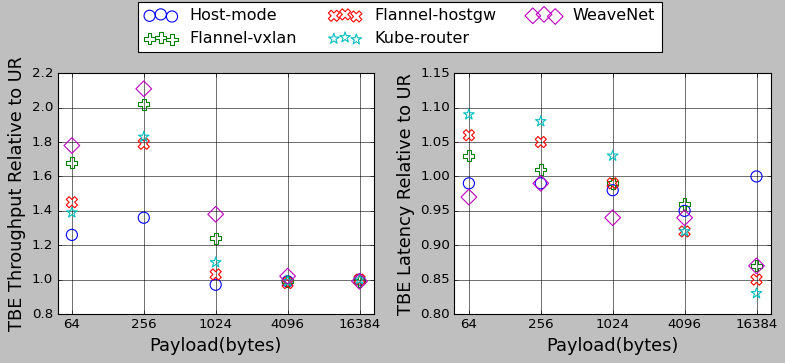

In [74]:
rthp = [[1.26, 1.36, 0.97, 0.99, 1.0],
[1.68, 2.02, 1.24, 0.99, 0.99],
[1.45, 1.79, 1.03, 0.98, 1.0],
[1.39, 1.83, 1.1, 0.99, 1.0],
[1.78, 2.11, 1.38, 1.02, 0.99]]

rlat = [[0.99, 0.99, 0.98, 0.95, 1.0],
[1.03, 1.01, 0.99, 0.96, 0.87],
[1.06, 1.05, 0.99, 0.92, 0.85],
[1.09, 1.08, 1.03, 0.92, 0.83],
[0.97, 0.99, 0.94, 0.94, 0.87]]

fig, ax = plt.subplots(1, 2, figsize=(10, 4), sharex=True)
bars = []
markers = ['o', 'P', 'X', '*', 'D', 's']
def helper(i, j, data, err, xlabel, ylabel, title=None):
    global ax, bars
    x = np.arange(len(data_len))
    if err is not None:
        # ax[j].bar(x+i*width, data[i], width=width, yerr=err[i])
        ax[j].scatter(x, data[i], marker=markers[i], c='',edgecolors='C%d'%i, s=100)
    else:
        ax[j].scatter(x, data[i], marker=markers[i], c='',edgecolors='C%d'%i, s=100)
    ax[j].grid(linestyle='-')
    ax[j].set_ylabel(ylabel, fontsize=16)
    ax[j].set_xlabel(xlabel, fontsize=16)
    ax[j].set_title(title, fontsize=16)
    bars.append(ax[j])


plt.xticks(x, data_len)

for j in range(5):
    helper(j, 0, rthp, None, 'Payload(bytes)', 'TBE Throughput Relative to UR')
for j in range(5):
    helper(j, 1, rlat, None, 'Payload(bytes)', 'TBE Latency Relative to UR')

fig.legend(bars[:5],     # The line objects
           labels=labels,   # The labels for each line
           loc="center",   # Position of legend
           borderaxespad=0.1,    # Small spacing around legend box
           bbox_to_anchor=(0.5, 1.05),
           ncol=3
           )
plt.tight_layout()
plt.savefig('relcni.png', dpi=600, bbox_inches='tight')